In [1]:
import pickle as pkl
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
import torch
import random
from astropy.cosmology import Planck18

C:\Users\tsl62\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_data(path, dates_path, filter_zerr = True):
    num_rej = 0
    num_pass = 0
    
    dates = pd.read_hdf(dates_path)
    load = h5py.File(path, 'r')
    targets = []

    for field in load["fields"]:
        datafile = load["fields"][field]
        for key in datafile.keys():
            obs = {}
            for item in datafile[key].keys():
                obs_dict = {}
                for key2 in datafile[key][item].keys():
                    obs_dict[key2] = np.asarray(datafile[key][item][key2])
                obs[item] = obs_dict
                # obs[item] = datafile[key][item]
                
            ztf_slice = dates[dates["targetid"] == int(key)]
            if(len(ztf_slice) == 0):
                num_rej += 1
                continue
            elif(len(ztf_slice) > 0):
                ztf_slice = ztf_slice.iloc[0]
                
            DESI_date = np.asarray(ztf_slice["mjd"])

            if(filter_zerr and float(ztf_slice["zwarn"]) != 0):
                num_rej += 1
                continue


            obs["desi_date"] = DESI_date
            obs["targetid"] = key
            obs["z"] = float(ztf_slice["z"])
            obs["zerr"] = float(ztf_slice["zerr"])
            num_pass += 1
                
            targets.append(obs)
    print(f"{num_pass} samples successfully loaded and {num_rej / (num_rej + num_pass)} % of data had ztf data errors")
    return targets

In [3]:
def fluxToMag(f):
    m  = -2.5 * np.log10(f)
    return m

def magToFlux(m):
    f = 10**(-0.4*m)
    return f

def fluxToMagErr(f, df):
    dm = np.abs(2.5 / np.log(10) * df / f)

    return dm

def magToFluxErr(m, dm):
    df = np.abs(dm * 10**(-0.4*m) * np.log(10)/-2.5)
    return df

mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def correctMag(m, z):
    dmod = distmodWithCache(z)
    return m - dmod

def correctMagErr(merr, z, zerr):
    d_upper = distmodWithCache(z+zerr)
    d_lower = distmodWithCache(z-zerr)

    d_err = np.abs(d_upper - d_lower)/2
    return np.sqrt(merr**2+d_err**2)

In [4]:
def trimLC(hmjd, mag, magerr, catflags):
    index = np.full(len(hmjd), False)
    index = np.logical_or(index, (catflags & 32768)==0)
    return hmjd[index], mag[index], magerr[index]

def filter_catflags(data_dict):
    total_len = 0
    removed_len = 0
    for obs in data_dict:
        for key in ["g", "i", "r"]:
            if len(obs[key]) == 0:
                continue

            new_hmjd, new_mag, new_magerr = trimLC(obs[key]["hmjd"], obs[key]["mag"], obs[key]["magerr"], obs[key]["catflags"])
            total_len += len(obs[key]["hmjd"])
            removed_len += len(new_hmjd)
            obs[key].pop("catflags")

            obs[key]["hmjd"] = new_hmjd
            obs[key]["mag"] = new_mag
            obs[key]["magerr"] = new_magerr

    print(f"Data successfully filtered! {round((total_len - removed_len - 0.0)/total_len * 100, 3)}% of data had catflag errors")

def correct_redshift(data_dict):
    for obs in data_dict:
        for key in ["g", "i", "r"]:
            if len(obs[key]) == 0:
                continue
            mag = obs[key]["mag"]
            magerr = obs[key]["magerr"]

            z = obs["z"]
            zerr = obs["zerr"]
            cmag = []
            cmagerr = []

            for i in range(len(mag)):
                cmag.append(correctMag(mag[i], z))
                cmagerr.append(correctMagErr(magerr[i], z, zerr))

            obs[key]["mag"] = cmag
            obs[key]["magerr"] = cmagerr

In [5]:
def weightedMean(data, weights, dates, obs_date = 0, tolerance = float("inf"), flux = True):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

In [27]:
def plot_with_desi_compare(data, err, dates, DESI_date, tolerance, targetID, dispersion = None):
    wmean, wmean_err = weightedMean(data, err, dates, DESI_date, tolerance, False)
    wmean_f, wmean_err_f = weightedMean(data, err, dates, DESI_date, tolerance, True)
    if(wmean == None or wmean_f == None):
        return
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    fig.suptitle(f"ZTF Magnitude with Error for {targetID}")

    if(tolerance > 2000):
        ax.errorbar(dates, data, yerr = err, fmt="o", label = "ZTF Mag. w/ Error")
    else:
        inner_dates = [dates[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]
        inner_data = [data[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]
        inner_err = [err[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]

        outer_dates = [dates[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]
        outer_data = [data[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]
        outer_err = [err[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]

        if(len(inner_dates) > 0):
            ax.errorbar(inner_dates, inner_data, yerr = inner_err, fmt="o", label = "ZTF Mag. w/ Error")
        if(len(outer_dates) > 0):
            ax.errorbar(outer_dates, outer_data, yerr = outer_err, fmt="o", alpha = 0.5)


    if(dispersion):
        ax.axhline(wmean + dispersion, c = "pink", linestyle = "--", label = "Mean Mag. w/ Dispersion")
        ax.axhline(wmean - dispersion, c = "pink", linestyle = "--")

    ax.axhline(wmean, c = "orange", label = "Mean Mag. w/ Error")
    ax.axhline(wmean + wmean_err, c = "orange", linestyle = "--")
    ax.axhline(wmean - wmean_err, c = "orange", linestyle = "--")

    ax.axhline(wmean_f, c = "green", label = "Mean Mag. w/ Error (flux)")
    ax.axhline(wmean_f + wmean_err_f, c = "green", linestyle = "--")
    ax.axhline(wmean_f - wmean_err_f, c = "green", linestyle = "--")
    
    ax.axvline(DESI_date, c = "red", label = "DESI observation date w/window")
    if(tolerance < 2000):
        ax.axvline(DESI_date + tolerance, c = "red", linestyle = "--")
        ax.axvline(DESI_date - tolerance, c = "red", linestyle = "--")
    fig.legend()

In [7]:
def generate_plots_compare(data_dict, n, tolerance):
    for i in range(n):
        field = random.choice(data_dict)

        for channel in ["g", "i", "r"]:
            obs = field[channel]
            if(len(obs) == 0):
                continue
            DESI_date = field["desi_date"]
            mag = obs["mag"]
            magerr = obs["magerr"]
            date = obs["hmjd"]

            plot_with_desi_compare(mag, magerr, date, DESI_date, tolerance, field["targetid"])
            break

In [8]:
data = preprocess_data("../../data/targetidLC.hdf5", "../../data/dates.hdf5")
filter_catflags(data)

10885 samples successfully loaded and 0.03080758614549016 % of data had ztf data errors
Data successfully filtered! 4.961% of data had catflag errors


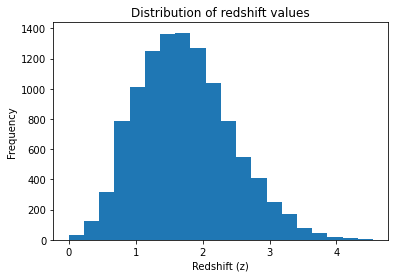

In [9]:
redshifts = [obs["z"] for obs in data]
plt.hist(redshifts, bins = 20)
plt.title("Distribution of redshift values")
plt.xlabel("Redshift (z)")
plt.ylabel("Frequency")
plt.show()


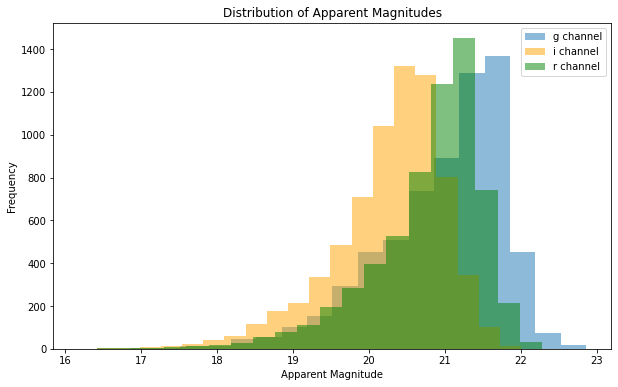

In [10]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in data:
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 20)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 20)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 20)

plt.title("Distribution of Apparent Magnitudes")
plt.xlabel("Apparent Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [11]:
dates = pd.read_hdf("../../data/dates.hdf5")
dates

,targetid,night,mjd,z,zerr,zwarn
0,39627322701128888,20211031,59519.274054,3.014808,0.000357,0.0
1,39627322705320844,20211031,59519.274054,1.571307,0.001500,0.0
2,39627328392795543,20211031,59519.274054,1.696314,0.000211,0.0
3,39627328392797885,20211031,59519.274054,0.790887,0.000052,0.0
4,39627328396985227,20211031,59519.274054,0.272107,0.000006,0.0
...,...,...,...,...,...,...
1812726,39637336077635434,20211024,59512.155395,1.566837,0.000891,0.0
1812727,39637336077636181,20211024,59512.155395,2.864394,0.000437,0.0
1812728,39637336077636286,20211024,59512.155395,2.085027,0.000758,0.0
1812729,39637341018522415,20211111,59530.091748,1.990966,0.000164,0.0


In [12]:
correct_redshift(data)

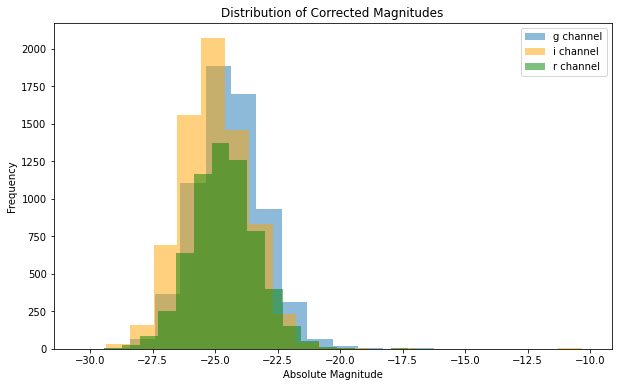

In [13]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in data:
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 20)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 20)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 20)

plt.title("Distribution of Corrected Magnitudes")
plt.xlabel("Absolute Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

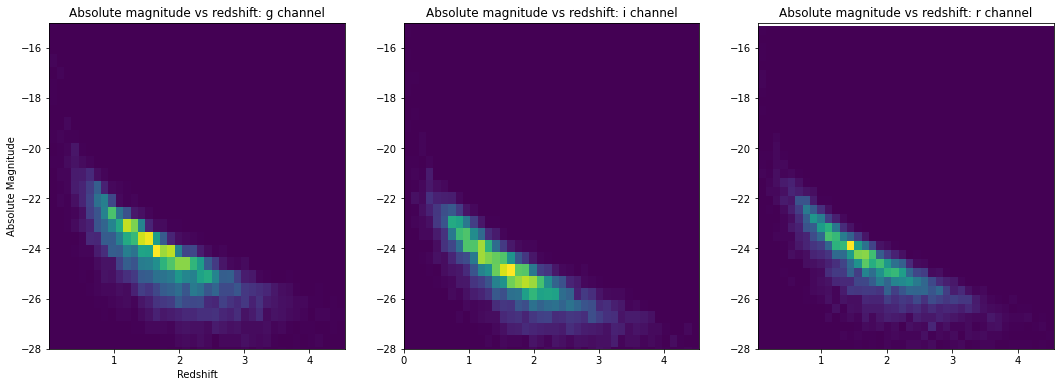

In [14]:
closest_dates = {"g": [], "i": [], "r": [], "gr":[], "ir":[], "rr":[]}

for obs in data:
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)
        redshift = obs["z"]
        closest_dates[ch + "r"].append(redshift)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].hist2d(closest_dates["gr"], closest_dates["g"], label = "g channel", bins = 40)
ax[1].hist2d(closest_dates["ir"], closest_dates["i"], label = "i channel", bins = 40)
ax[2].hist2d(closest_dates["rr"], closest_dates["r"], label = "r channel", bins = 40)

ax[0].set_title("Absolute magnitude vs redshift: g channel")
ax[1].set_title("Absolute magnitude vs redshift: i channel")
ax[2].set_title("Absolute magnitude vs redshift: r channel")

ax[0].set_ylim(-28, -15)
ax[1].set_ylim(-28, -15)
ax[2].set_ylim(-28, -15)

ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Absolute Magnitude")
plt.show()

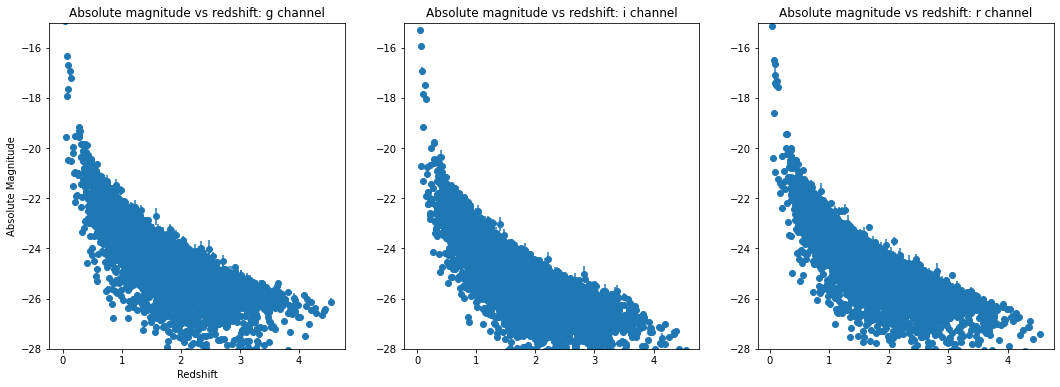

In [15]:
closest_dates = {"g": [], "i": [], "r": [], "gr":[], "ir":[], "rr":[], "gre":[], "ire":[], "rre":[], "ge": [], "ie":[], "re":[]}

for obs in data:
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date, cerr = weightedMean(obs[ch]["mag"], obs[ch]["magerr"], obs[ch]["hmjd"])
        closest_dates[ch].append(closest_date)
        closest_dates[ch + "e"].append(cerr)
        redshift = obs["z"]
        redshift_err = obs["zerr"]
        closest_dates[ch + "r"].append(redshift)
        closest_dates[ch + "re"].append(redshift_err)


fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].errorbar(closest_dates["gr"], closest_dates["g"], yerr = closest_dates["ge"], xerr = closest_dates["gre"], label = "g channel", fmt = "o")
ax[1].errorbar(closest_dates["ir"], closest_dates["i"], yerr = closest_dates["ie"], xerr = closest_dates["ire"], label = "i channel", fmt = "o")
ax[2].errorbar(closest_dates["rr"], closest_dates["r"], yerr = closest_dates["re"], xerr = closest_dates["rre"], label = "r channel", fmt = "o")

ax[0].set_title("Absolute magnitude vs redshift: g channel")
ax[1].set_title("Absolute magnitude vs redshift: i channel")
ax[2].set_title("Absolute magnitude vs redshift: r channel")

ax[0].set_ylim(-28, -15)
ax[1].set_ylim(-28, -15)
ax[2].set_ylim(-28, -15)

ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Absolute Magnitude")
plt.show()

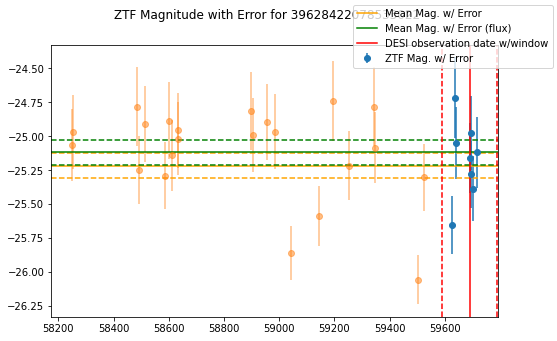

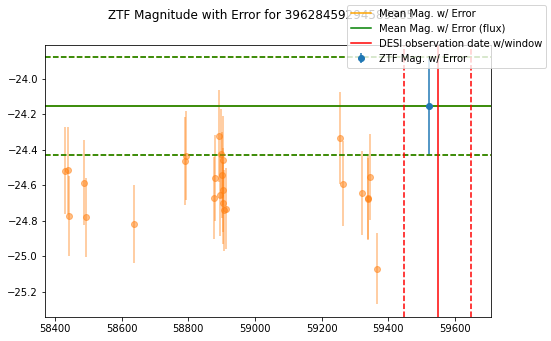

In [16]:
generate_plots_compare(data, 3, 100)

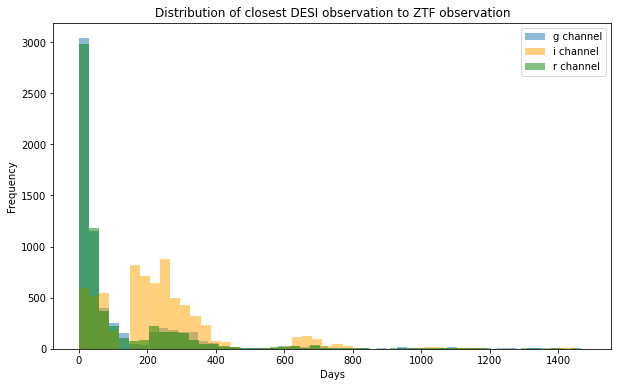

In [17]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in data:
    ztf_date = obs["desi_date"]
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = min([np.abs(date - ztf_date) for date in obs[ch]["hmjd"]])
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 50)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 50)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 50)

plt.title("Distribution of closest DESI observation to ZTF observation")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [18]:
def chisq(observed, expected, err):

    res = [observed[i]-expected[i] for i in range(len(expected))]
    norm_res = [res[i]/err[i] for i in range(len(res))]
    return np.sum(np.power(norm_res,2))/len(obs)

def calc_dispersion_chi(mag, magerr, dates, obs_date = 0, threshold = float("inf")):
    mean, sterr = weightedMean(mag, magerr, dates, obs_date, threshold)

    chisq_obs = chisq(mag, [mean]*len(mag), magerr)
    return chisq_obs

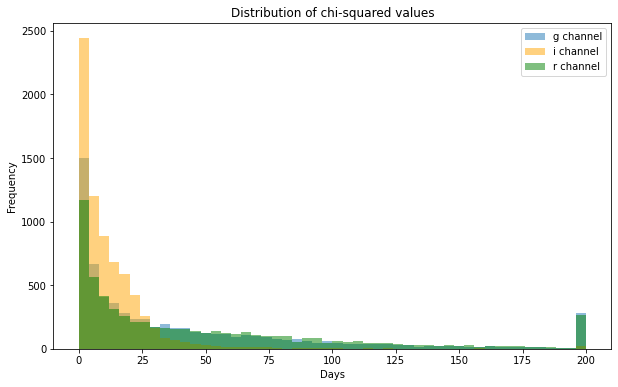

In [19]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in data:
    ztf_date = obs["desi_date"]
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue
        closest_dates[ch].append(min(calc_dispersion_chi(obs[ch]["mag"], obs[ch]["magerr"], obs[ch]["hmjd"]), 200))

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 50)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 50)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 50)

plt.title("Distribution of chi-squared values")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [29]:
import numpyro

import numpyro.distributions as dist
from jax import random

from numpyro.infer import MCMC, NUTS

def calc_dispersion_bayesian(mag, magerr, dates, obs_date = 0, threshold = float("inf")):
    f_mag = []
    f_magerr = []
    for i in range(len(mag)):
        if(np.abs(dates[i] - obs_date) < threshold):
            f_mag.append(mag[i])
            f_magerr.append(magerr[i])

    f_mag = np.array(f_mag)
    f_magerr = np.array(f_magerr)
    mean_mag, _= weightedMean(mag, magerr, dates, obs_date, threshold)

    print(np.std(f_magerr))
    
    def simulate_measurement(J, measurement_err, y = None):
        disp = numpyro.sample("dispersion", dist.HalfCauchy(2))

        with numpyro.plate('J', J):
            act_mag = numpyro.sample("true_mag", dist.Normal(mean_mag, disp))

            numpyro.sample('obs', dist.Normal(act_mag, measurement_err), obs=y)

    nuts_kernel = NUTS(simulate_measurement)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1600)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, len(f_mag), f_magerr, y=f_mag, extra_fields=('potential_energy',))
    mcmc.print_summary()  

In [30]:
calc_dispersion_bayesian(np.array(data[0]["g"]["mag"]), np.array(data[0]["g"]["magerr"]), np.array(data[0]["g"]["hmjd"]))

0.003345493476829651


sample: 100%|██████████| 2100/2100 [00:03<00:00, 688.72it/s, 15 steps of size 3.28e-01. acc. prob=0.86] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   dispersion      0.11      0.00      0.11      0.10      0.12   2571.60      1.00
  true_mag[0]    -26.90      0.04    -26.90    -26.95    -26.84   4128.48      1.00
  true_mag[1]    -27.05      0.04    -27.05    -27.10    -26.99   4199.10      1.00
  true_mag[2]    -26.91      0.04    -26.91    -26.97    -26.84   5118.82      1.00
  true_mag[3]    -26.89      0.04    -26.89    -26.95    -26.82   3791.93      1.00
  true_mag[4]    -26.99      0.04    -26.99    -27.04    -26.93   4122.46      1.00
  true_mag[5]    -26.99      0.03    -26.99    -27.05    -26.94   3834.53      1.00
  true_mag[6]    -26.94      0.04    -26.94    -27.00    -26.89   4173.29      1.00
  true_mag[7]    -26.89      0.04    -26.89    -26.95    -26.82   3530.47      1.00
  true_mag[8]    -26.84      0.04    -26.84    -26.90    -26.78   3047.35      1.00
  true_mag[9]    -26.92      0.04    -26.92    -26.98    -26.86   3889.67  

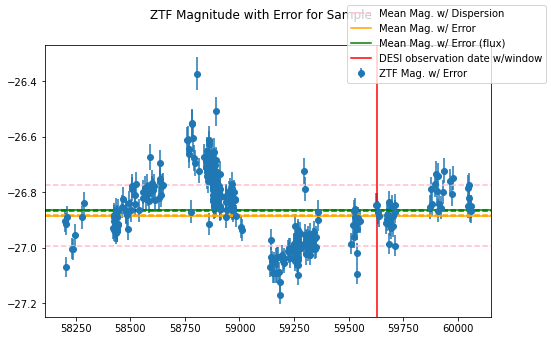

In [31]:
plot_with_desi_compare(np.array(data[0]["g"]["mag"]), np.array(data[0]["g"]["magerr"]), np.array(data[0]["g"]["hmjd"]), data[0]["desi_date"], 10000, "Sample", 0.11)